# Tutorial 1 : Thermomechanical Model

# A quick Lithospheric Model with visco-plastic non-linear rheologies

version 0.2
Romain Beucher
romain.beucher@unimelb.edu.au

The following tutorial presents a simple usage of the geodynamics module.
The *geodynamics* module intents to facilitate rapid prototyping of geodynamics models. It can be seen as a set of high-level functions within the underworld ecosystem. It is a means to quickly get the user into Underworld modelling and assumes very little knowledge in coding. The module make some assumptions based on how the user defines the boundary conditions and the properties of the materials (rocks, phases). 

Its simplicity comes with a relatively more rigid workflow (compared to the classic Underworld functions).
However, the user can easily break the high level objects and get back to core Underworld function at any step of model design. As we think the low-level interface is more flexible, and in so allows for more complex models, we strongly encourage users to explore and break the High Level functions. We hope that the user will naturally move to the low-level functionalities as he or her gets more confident, and by doing so will access the wide range of possibilities offered by Underworld.

The module can be imported as follows:

In [1]:
import UWGeodynamics as GEO

# Working with units

Note that this is not an obligation and you can use values without units 


The geodynamics module enables usage of a broad range of units using a *UnitRegistry*. You can attach a unit to any value that you need to define. A value with a units attached becomes a *Quantity* python object. The geodynamics module take care of the conversion internally so you may use any units that you think are appropriate. You can also mix them.

The module will also try to work out a scaling of the values to help the computation process. The user can chose to alter the way his or her values are scaled or can rely on the default options.

To use the units system, you can link the unit registry as follow:

In [2]:
u = GEO.UnitRegistry

## Scaling

In [3]:
half_rate = 1.8 * u.centimeter / u.year
model_length = 360e3 * u.meter
surfaceTemp = 273.15 * u.degK
baseModelTemp = 1603.15 * u.degK
bodyforce = 3300 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2
KT = (baseModelTemp - surfaceTemp)

GEO.sca.scaling["[length]"] = KL
GEO.sca.scaling["[time]"] = Kt
GEO.sca.scaling["[mass]"]= KM
GEO.sca.scaling["[temperature]"] = KT

# Define the external geometry

The first step is to define the geometry of our problem, essentially a box on which we will apply some physical constraints and that will contain a set of materials. We can think of it as an "universe".
The "laws" and their effects are calculated on a mesh, that mesh discretized our universe into finite elements.

The geodynamics module allows you to quickly set up a model by creating a *Model* object.
A series of arguments are required to define a *Model*:

    - The number of elements in each direction elementRes=(nx, ny);
    - The minimum coordinates for each axis minCoord=(minX, minY)
    - The maximum coordinates for each axis maxCoord=(maxX, maxY)
    - A vector that defines the magnitude and direction of the gravity components gravity=(gx, gy)
 

In [4]:
Model = GEO.Model(elementRes=(180, 60), 
                  minCoord=(0. * u.kilometer, -110. * u.kilometer), 
                  maxCoord=(360. * u.kilometer, 10. * u.kilometer), 
                  gravity=(0.0, -9.81 * u.meter / u.second**2))

In [5]:
Model.outputDir="outputs"

# Add some Materials

Now that we have our "universe" (box, sand pit) ready, we need to fill it with some materials.
The *geodynamics* module is designed around that idea of materials, which are essentially a way to define physical properties across the Model domain.

A material (or a phase) is first defined by the space it takes in the box (its shape).

In [6]:
Model.diffusivity = 1e-6 * u.metre**2 / u.second 
Model.capacity    = 1000. * u.joule / (u.kelvin * u.kilogram)
Model.thermalExpansivity = 3e-5 / u.kelvin

The Model we are building is essentially a layered cake. The geodynamics module provide and easy way to define a layer by defining shape as *layer* and specifying its *top* and *bottom*. The order is important: when 2 shapes overlay each other, only the second is used.

In [7]:
# Air Layer
air = Model.add_material(name="Air", shape=GEO.shapes.Layer(top=Model.top, bottom=0 * u.kilometer))
air.density = 1. * u.kilogram / u.metre**3
air.radiogenicHeatProd = 0.0
air.capacity = 100. * u.joule / (u.kelvin * u.kilogram)
air.thermalExpansivity = 0.0

In [8]:
# Uppercrust Layer
uppercrust = Model.add_material(name="Upper Crust", shape=GEO.shapes.Layer(top=0. * u.kilometer, bottom=-20. * u.kilometer))
uppercrust.density  = 2620. * u.kilogram / u.metre**3
uppercrust.radiogenicHeatProd = 0.7 * u.microwatt / u.meter**3

In [9]:
# Midcrust Layer
midcrust = Model.add_material(name="Mid Crust", shape=GEO.shapes.Layer(top=-20. * u.kilometer, bottom=-25. * u.kilometer))
midcrust.density = 2900. * u.kilogram / u.metre**3
midcrust.radiogenicHeatProd = 0.6 * u.microwatt / u.meter**3

In [10]:
# Sediment
sediment = Model.add_material(name="Sediment")
sediment.density = 2900. * u.kilogram / u.metre**3
sediment.radiogenicHeatProd = 0.6 * u.microwatt / u.meter**3

In [11]:
# Heavy Crust Layer
heavycrust = Model.add_material(name="Heavy Crust", shape=GEO.shapes.Layer(top=-35. * u.kilometer, bottom=-40. * u.kilometer))
heavycrust.density  = 2900. * u.kilogram / u.metre**3
heavycrust.radiogenicHeatProd = 0.6 * u.microwatt / u.meter**3

In [12]:
# Lower Crust Layer
lowercrust = Model.add_material(name="Lower Crust",shape=GEO.shapes.Layer(top=-25. * u.kilometer, bottom=-60. * u.kilometer))
lowercrust.density  = 2800. * u.kilogram / u.metre**3
lowercrust.radiogenicHeatProd = 0.4 * u.microwatt / u.meter**3

In [13]:
# Mantle Layer

mantle = Model.add_material(name="Mantle", shape=GEO.shapes.Layer(top=-60. * u.kilometer, bottom=Model.bottom))
mantle.density = 3370. * u.kilogram / u.metre**3
mantle.radiogenicHeatProd = 0.02e-6 * u.microwatt / u.meter**3

Now we want to define the fault. We can do that by specifying a list of vertices defining the polygon shape.

In [14]:
# Fault
vertices = [(169.  * u.kilometer,  0. * u.kilometer),
            (171. * u.kilometer,  0. * u.kilometer),
            (191. * u.kilometer, -20. * u.kilometer),
            (189. * u.kilometer, -20. * u.kilometer)]

fault = Model.add_material(name="Fault", shape=GEO.shapes.Polygon(vertices))
fault.density = 2620. * u.kilogram / u.metre**3
fault.radiogenicHeatProd = 0.7 * u.microwatt / u.meter**3

We can visualize the material field by calling the *plot_material()* method.


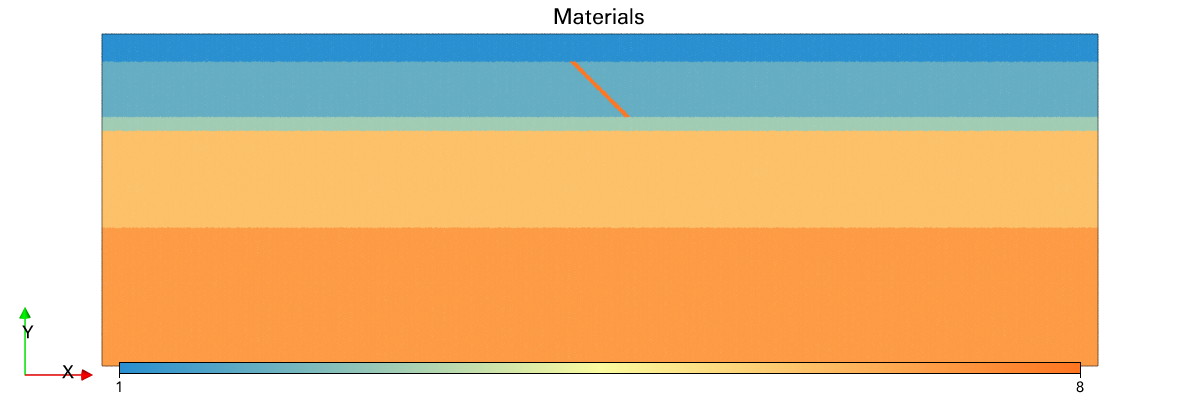

In [15]:
Fig = Model.plot.material(projected=False, figsize=(1200,400), fn_size=2.)

In the example above, I have intentionally defined the *heavy crust* layer before the *lower crust*. Those two layers are defined in the same interval and only the *lower crust* appears in the above plot.
It is possible to change the drawing order of the materials once all the materials have been defined:

In [16]:
Model.material_drawing_order = [fault, mantle, heavycrust, lowercrust, midcrust, uppercrust, air, sediment]


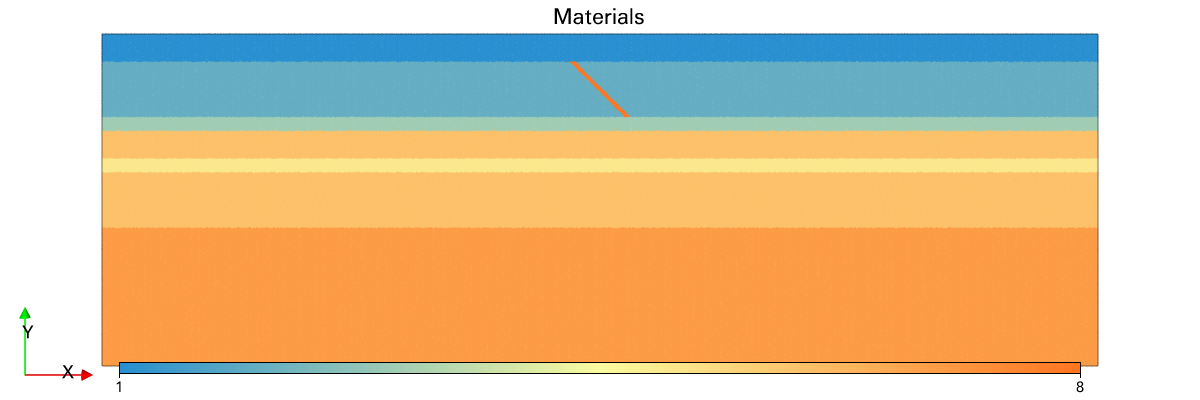

In [17]:
Fig = Model.plot.material(projected=False, figsize=(1200,400), fn_size=2.)

# Define Viscosities

The rheology library contains some commonly used rheologies stored in a python dictionary structure. We can list the keys defining the rheologies as follows:

In [18]:
rh = GEO.ViscousCreepRegistry()

In [19]:
air.viscosity        = 1e19 * u.pascal * u.second
uppercrust.viscosity = rh.Patterson_et_al_1990
sediment.viscosity   = rh.Patterson_et_al_1990
midcrust.viscosity   = rh.Goetze_et_al_1978
lowercrust.viscosity = rh.Wang_et_al_2012
heavycrust.viscosity = rh.Goetze_et_al_1978
mantle.viscosity     = rh.Hirth_et_al_2003
fault.viscosity      = 1e19 * u.pascal * u.second

# Define Plasticity

Plastic behavior is assigned using the same approach as for viscosities.

In [20]:
pl = GEO.PlasticityRegistry()

In [21]:
uppercrust.plasticity = pl.Rey_et_al_2010_UpperCrust
sediment.plasticity   = pl.Rey_et_al_2010_UpperCrust
midcrust.plasticity   = pl.Rey_et_al_2010_UpperCrust
lowercrust.plasticity = pl.Rey_et_al_2010_LowerCrust
heavycrust.plasticity = pl.Rey_et_al_2010_LowerCrust
fault.plasticity      = pl.Rey_et_al_2010_Mantle

## Temperature Boundary Condition

In [22]:
Model.set_temperatureBCs(top=293.15 * u.degK, 
                         bottom=1603.15 * u.degK, 
                         materials=[(mantle, 1603.15 * u.degK), (air, 293.15 * u.degK )])

## Velocity Boundary Conditions

In [23]:
Model.set_velocityBCs(left=[-1.8 * u.centimeter / u.year, None],
                       right=[1.8 * u.centimeter / u.year, None],
                       bottom=GEO.LecodeIsostasy(reference_mat=mantle.index))

In [24]:
# Model.surfaceProcesses = GEO.SPM.Badlands(airIndex=[air.index], sedimentIndex=[sediment.index],
#                                           XML="badlands.xml", resolution=1. * u.kilometer, 
#                                           checkpoint_interval=2000 * u.years)

## Run Model

In [25]:
Model.init_model()


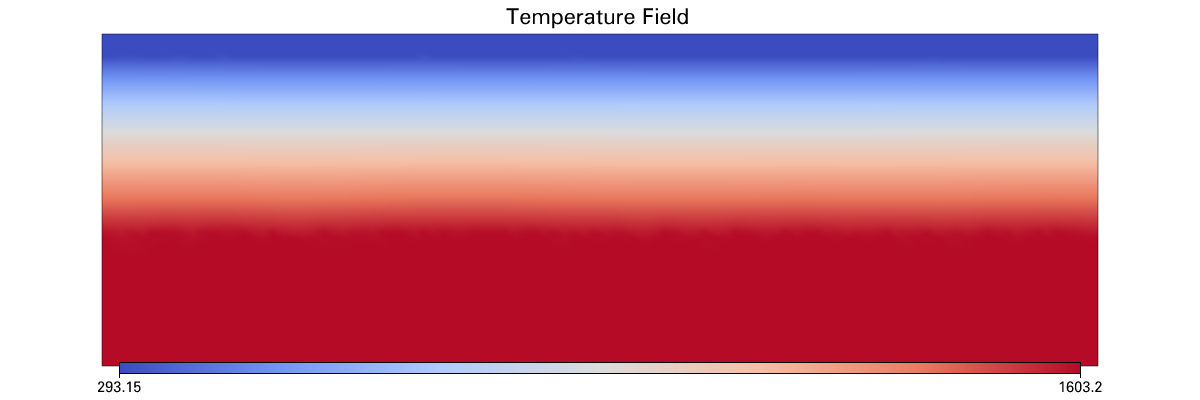

In [28]:
Fig = Model.plot.temperature(figsize=(1200,400))


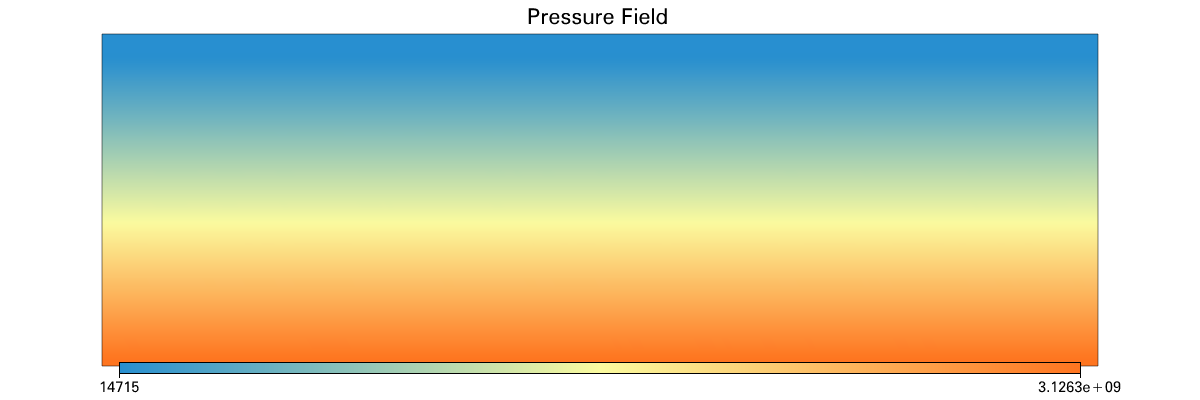

In [29]:
Fig = Model.plot.pressureField(figsize=(1200,400))

In [30]:
Model.solver.set_inner_method("mumps")
Model.solver.set_penalty(1e6)

In [27]:
Model.run_for(30000.* u.years)

Time:  30000.0 year



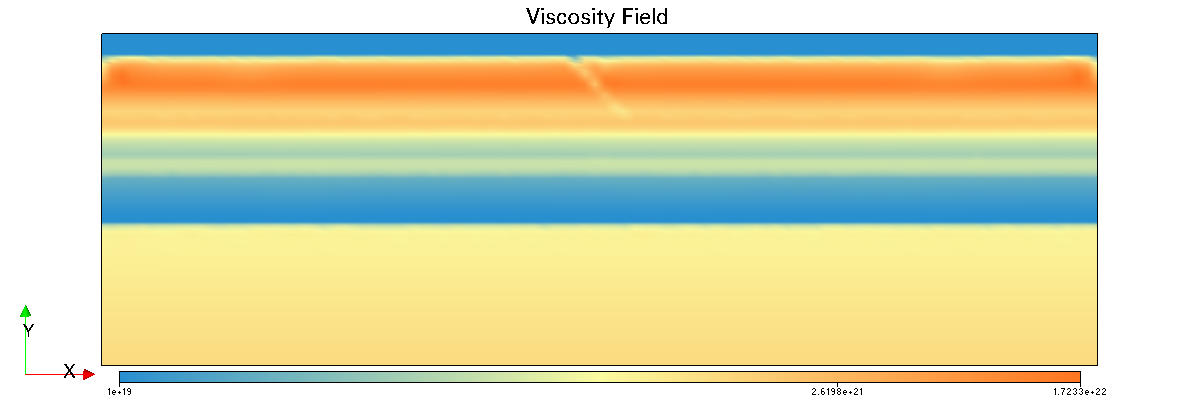

In [31]:
Fig = Model.plot.viscosity(projected=True)


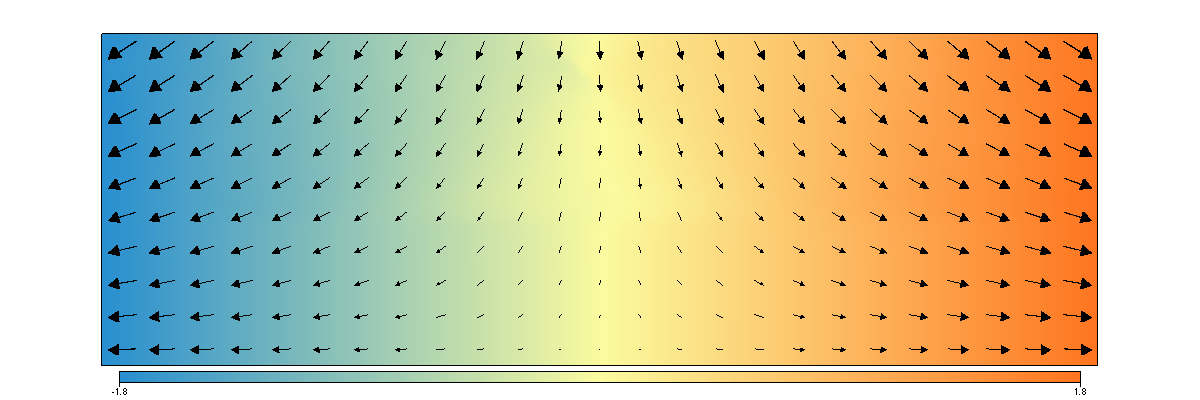

In [32]:
Fig = Model.plot.velocityField()


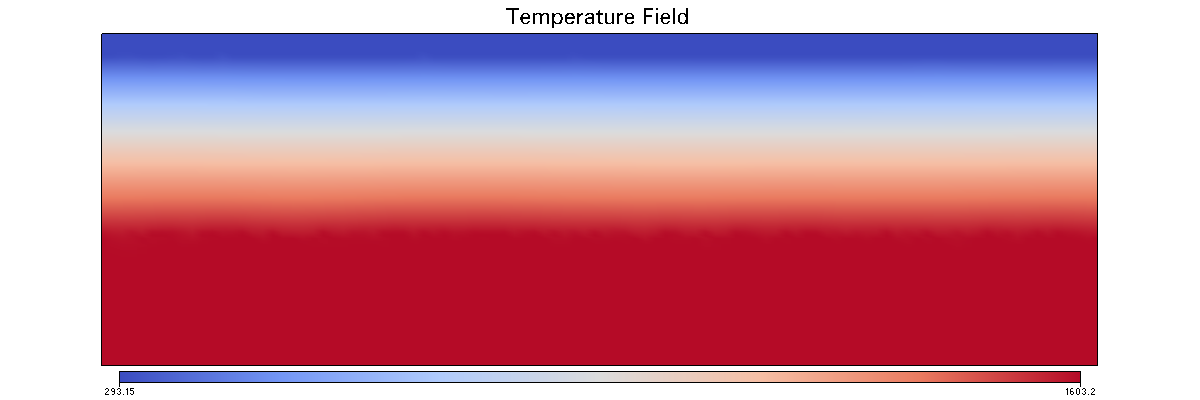

In [33]:
Fig = Model.plot.temperature()


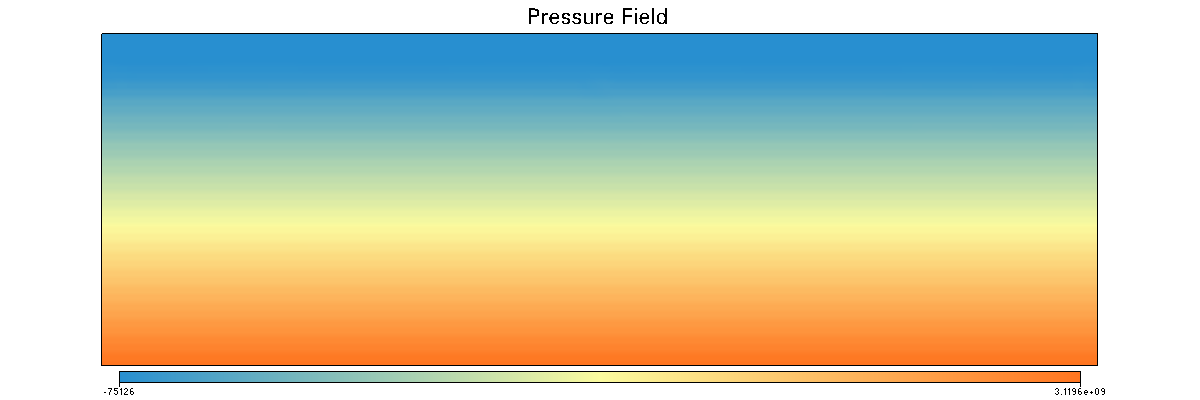

In [34]:
Fig = Model.plot.pressureField()

In [35]:
Model.run_for(1.0 * u.megayear)

Time:  0.0784448873203 megayear
Time:  0.12628590276 megayear
Time:  0.1740432703 megayear
Time:  0.22300500941 megayear
Time:  0.269434330896 megayear
Time:  0.319620086978 megayear
Time:  0.367380420807 megayear
Time:  0.416659527692 megayear
Time:  0.46375864781 megayear
Time:  0.49932901373 megayear
Time:  0.52014969419 megayear
Time:  0.542386266736 megayear
Time:  0.561549855013 megayear
Time:  0.583908953069 megayear
Time:  0.603031700022 megayear
Time:  0.626144163393 megayear
Time:  0.644166262706 megayear
Time:  0.666594490092 megayear
Time:  0.68474595772 megayear
Time:  0.706821879349 megayear
Time:  0.725012948505 megayear
Time:  0.747950627923 megayear
Time:  0.765876470932 megayear
Time:  0.788087654067 megayear
Time:  0.807153501519 megayear
Time:  0.829870914332 megayear
Time:  0.84927444804 megayear
Time:  0.872028749111 megayear
Time:  0.892960225243 megayear
Time:  0.916278894232 megayear
Time:  0.939360813095 megayear
Time:  0.966422961429 megayear
Time:  0.9929830


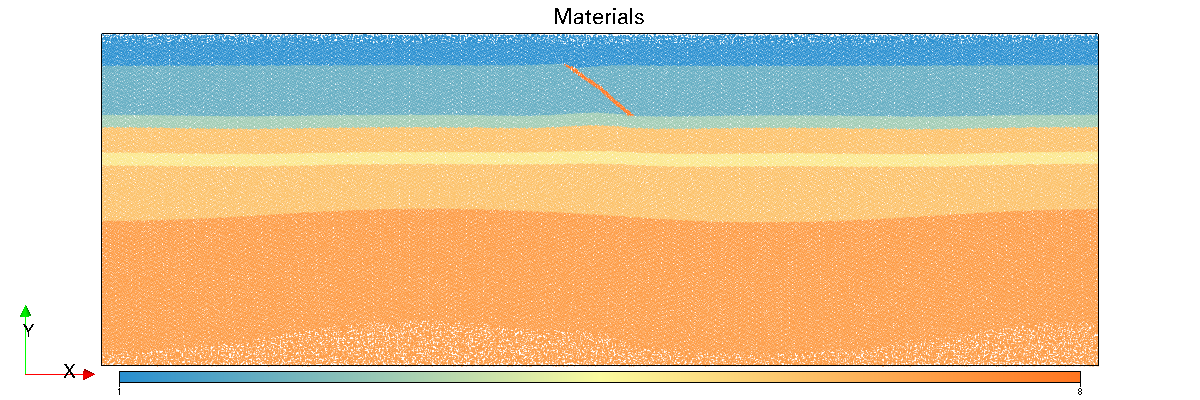

In [36]:
Fig = Model.plot.material(figsize=(1200,400))


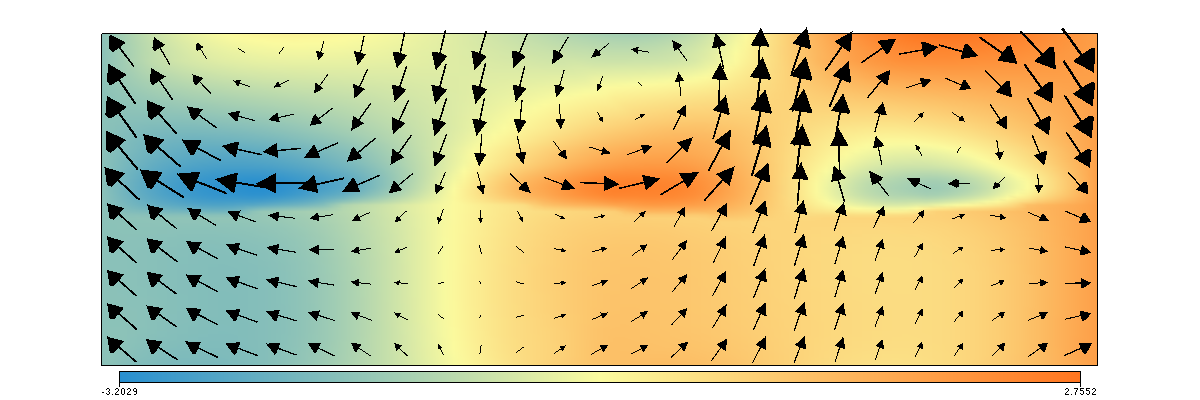

In [37]:
Fig = Model.plot.velocityField(figsize=(1200,400))


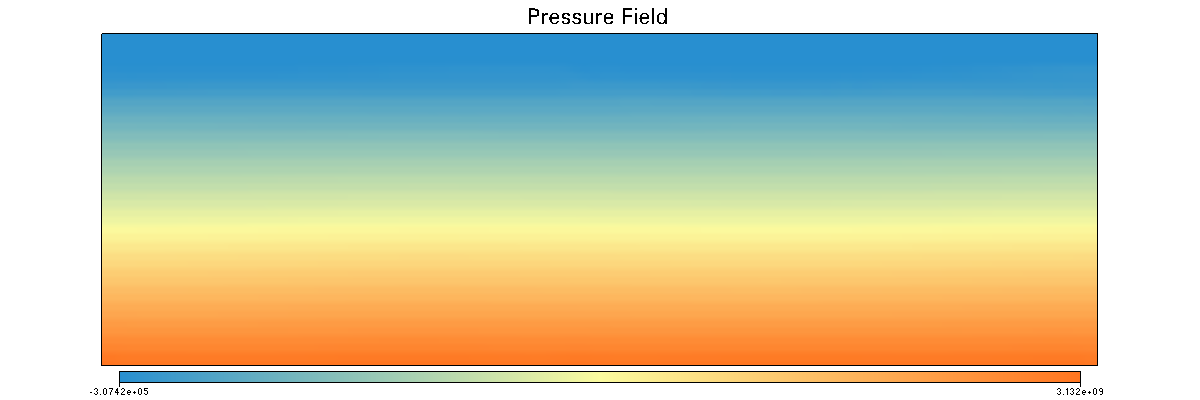

{'antialias': True,
 'axis': False,
 'background': 'white',
 'border': 1,
 'bordercolour': 'black',
 'margin': 34,
 'quality': 1,
 'resolution': (1200, 400),
 'rulers': False,
 'title': 'Pressure Field',
 'zoomstep': 0}

In [38]:
Fig = Model.plot.pressureField(figsize=(1200,400))